## Path Consistency Learning
### From the paper ["Bridging the Gap Between Value and Policy Based Reinforcement Learning"](https://arxiv.org/abs/1702.08892)

In [30]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

from env_simulator import ToyEnv

In [31]:
env = ToyEnv()

In [127]:
n_states = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
n_episodes = 2000
gamma = 0.98
tau = 0.0001
rollout_d = 5
c = 0.5
alpha = 0.4
max_steps_per_ep = 100
learning_rate_policy = 0.5
learning_rate_value = c*learning_rate_policy

In [33]:
class VNetwork():

    def __init__(self, n_states):
        self.trainable_weights = []
        self.n_states = n_states
        self.inputs = tf.placeholder(tf.float32, [None, n_states])
        self.weights = tf.Variable(tf.random_uniform([n_states, 1],0,0.01))
        self.trainable_weights.append(self.weights)
        self.outputs = tf.matmul(self.inputs, self.weights)
        self.gradval = tf.gradients(ys = self.outputs, xs = self.trainable_weights, name='val_grad_ops')
        self.gradweights = []
        self.train_ops = []
        for i, w in enumerate(self.trainable_weights):
            self.gradweights.append(tf.placeholder(tf.float32))
            self.train_ops.append(w.assign(w + learning_rate_value * self.gradweights[i]))

In [102]:
class PolicyNetwork():

    def __init__(self, n_states, n_actions):
        self.trainable_weights = []
        self.n_states = n_states
        self.n_actions = n_actions
        self.inputs = tf.placeholder(tf.float32, [None, n_states], name='pnet_input')
        self.weights = tf.Variable(tf.random_uniform([n_states, n_actions],0,0.01))
        self.trainable_weights.append(self.weights)
        self.outputs = tf.nn.softmax(tf.matmul(self.inputs, self.weights))
        self.selected_action = tf.placeholder(tf.int32, [None,])
        self.mask = tf.one_hot(self.selected_action, n_actions, on_value = True, off_value = False, dtype = tf.bool)
        self.logprobs = tf.boolean_mask(tf.log(self.outputs), self.mask) ## How to do uneven slicing...
        self.gradlogprobs = tf.gradients(ys = self.logprobs, xs = self.trainable_weights, name='policy_grad_ops')
        self.gradweights = []
        self.train_ops = []
        for i, w in enumerate(self.trainable_weights):
            self.gradweights.append(tf.placeholder(tf.float32, name='pnet_grad_weight_'+str(i)))
            self.train_ops.append(w.assign(w + learning_rate_policy * self.gradweights[i]))

    def choose_action(self, s, sess, tau, state_one_hot):
        prob = sess.run(self.outputs, feed_dict={self.inputs:state_one_hot[s:s+1]})[0].T
        a = np.random.choice(self.n_actions,1,p=prob)
        return a[0], prob

In [150]:
def train(exp, sess):
    exp = np.array(exp).reshape([-1,3])
    n = exp.shape[0]
    d = rollout_d
    if n <= rollout_d:
        d = n-1
#         print("Setting rollout to %d." % (d))
    gamma_exp = np.vectorize(lambda x: gamma**x)
    discount_vector = gamma_exp(np.arange(d))
#     print("Episode of length %d." % (n))
    states = exp[:,0]
    actions = exp[:,1]
    rewards = exp[:,2]
    log_probs = sess.run(pnet.logprobs, feed_dict={pnet.inputs:encode(states), pnet.selected_action:actions})
    grad_log_probs = []
    for i in range(n):
        g = sess.run(pnet.gradlogprobs, feed_dict={pnet.inputs:encode(states[i:i+1]), pnet.selected_action:actions[i:i+1]})
        grad_log_probs.append(g)
    grad_log_probs = np.swapaxes(np.array(grad_log_probs), 0, 1)
    vals = sess.run(vnet.outputs, feed_dict={vnet.inputs:encode(states)})
    grad_vals = []
    for i in range(n):
        g = sess.run(vnet.gradval, feed_dict={vnet.inputs:encode(states[i:i+1])})
        grad_vals.append(g)
    grad_vals = np.swapaxes(np.array(grad_vals), 0, 1)
    grad_pol_weights = {}
    grad_val_weights = {}
    for i in range(n-d):
        z = rewards[i:i+d] - tau*log_probs[i:i+d]
        c = -vals[i] + (gamma**d)*vals[i+d] + np.dot(discount_vector,z)
        for j, g in enumerate(grad_log_probs):
            grad = g[i]
            for k in range(d-1):
                grad += discount_vector[k+1]*g[i+k]  
            grad_pol_weights[j] = grad_pol_weights.get(j,np.zeros(grad.shape)) + c*grad
        for j, g in enumerate(grad_vals):
            grad = g[i] - (gamma**d)*g[i+d-1]
            grad_val_weights[j] = grad_val_weights.get(j,np.zeros(grad.shape)) + c*grad
    sess.run(pnet.train_ops, feed_dict=dict(zip(pnet.gradweights, grad_pol_weights.values())))
    sess.run(vnet.train_ops, feed_dict=dict(zip(vnet.gradweights, grad_val_weights.values())))

In [ ]:
exp_buffer = []
pnet = PolicyNetwork(n_states, n_actions)
vnet = VNetwork(n_states)

state_one_hot = np.eye(n_states)
encode = lambda x: state_one_hot[x.astype(int)]

rewards = [] # To hold total reward per episode
avg_rewards = [] # To hold running average of rewards per episode
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for ep in range(n_episodes):
        s,r,done = env.reset()
        n_step = 0
        ep_r = 0
        exp = []
        while not done:
            a, _ = pnet.choose_action(s, sess, epsilon, state_one_hot)
            s1,r,done = env.step(a)
            exp.extend([s,a,r])
            s = s1
            ep_r += r
            n_step += 1
            if n_step > max_steps_per_ep:
                break
        train(exp, sess)
        exp_buffer.append(exp)
        rewards.append(ep_r)
        avg_rewards.append(sum(rewards[-500:])/500.0)
        if len(exp_buffer) > 32:
            z = np.exp(alpha*np.array(rewards))
            sample_prob = (0.1 / len(exp_buffer)) + (0.9*z / np.sum(z))
            for _ in range(20):
                sampled_exp = [exp_buffer[i] for i in np.random.choice(len(exp_buffer), 1, p=sample_prob)]
                train(sampled_exp, sess)
        if not ep % 100:
            print("Episode #%d : Reward = %f, Avg Rew = %f" % (ep, ep_r, avg_rewards[-1]))    

Episode #0 : Reward = 1.000000, Avg Rew = 0.002000
Episode #100 : Reward = -1.000000, Avg Rew = -0.022000
Episode #200 : Reward = -1.000000, Avg Rew = -0.062000
Episode #300 : Reward = -1.000000, Avg Rew = -0.098000
Episode #400 : Reward = 1.000000, Avg Rew = -0.142000
Episode #500 : Reward = -1.000000, Avg Rew = -0.152000
Episode #600 : Reward = 1.000000, Avg Rew = -0.160000
Episode #700 : Reward = 1.000000, Avg Rew = -0.148000
Episode #800 : Reward = 1.000000, Avg Rew = -0.132000
Episode #900 : Reward = 1.000000, Avg Rew = -0.132000
Episode #1000 : Reward = 1.000000, Avg Rew = -0.132000
Episode #1100 : Reward = 1.000000, Avg Rew = -0.108000
Episode #1200 : Reward = -1.000000, Avg Rew = -0.152000
Episode #1300 : Reward = -1.000000, Avg Rew = -0.172000
Episode #1400 : Reward = -1.000000, Avg Rew = -0.164000


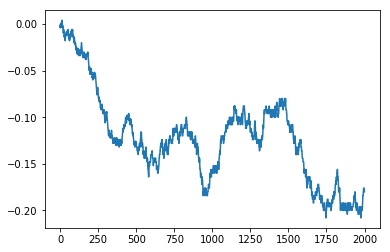

In [152]:
plt.plot(avg_rewards)

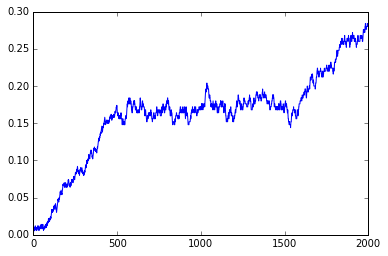

In [31]:
plt.plot(avg_rewards)